<h1>2) Deep Learning Architekturen für Zeitreihen</h1>
<h4>Dienstag 04.06.24 13:30 – 17:00 Uhr</h4>
<br>
--- <br>
2.1 Datenvorbereitung für Deep Learning Zeitreihenanalyse<br>
2.2 RNNs (von Hand) <br>
2.3 Fortsetzung: RNNs (mit Tensorflow) <br>
2.4 LSTMs (mit Tensorflow) <br>
---

In [28]:
# Für Zeitreihenoperationen 
import pandas as pd
import numpy as np

# Zum Plotten
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Für die Datenaufbereitung
from sklearn.preprocessing import MinMaxScaler

# Für die Auswertung
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
# Zum Ignorieren nerviger Warnungen 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Zum GPU Teilen
#from utils_code.share_gpu import restrict_gpu_memory
#restrict_gpu_memory(4500)

### 2.1 Vorbereitung Daten für Deep Learning Zeitreihenanalyse

In [30]:
ene = pd.read_csv("germany_fossil_renew.csv", sep=";")
ene['Datum'] = pd.to_datetime(ene['Datum'])
ene['Datum'].freq = 'M'
ene.set_index('Datum', inplace=True)
wind = ene[['Wind']]
wind.head()

c:\temp\ipykernel_9440\3840975310.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,Wind
Datum,
2016-01-01,9771
2016-02-01,10371
2016-03-01,6331
2016-04-01,6235
2016-05-01,6445


In [31]:
scaler = MinMaxScaler()
scaler.fit(wind)
winds = scaler.transform(wind)
winds[:10]

array([[0.35258769],
       [0.38937945],
       [0.14164827],
       [0.13576159],
       [0.1486387 ],
       [0.02532499],
       [0.02532499],
       [0.03139563],
       [0.        ],
       [0.08094187]])

In [32]:
data = winds

In [33]:
time = wind.index.values.reshape(-1, 1)
time[:10]

array([['2016-01-01T00:00:00.000000000'],
       ['2016-02-01T00:00:00.000000000'],
       ['2016-03-01T00:00:00.000000000'],
       ['2016-04-01T00:00:00.000000000'],
       ['2016-05-01T00:00:00.000000000'],
       ['2016-06-01T00:00:00.000000000'],
       ['2016-07-01T00:00:00.000000000'],
       ['2016-08-01T00:00:00.000000000'],
       ['2016-09-01T00:00:00.000000000'],
       ['2016-10-01T00:00:00.000000000']], dtype='datetime64[ns]')

In [34]:
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.2)

In [35]:
data_train, data_val, data_test = winds[0:train_size], winds[train_size:train_size+val_size], winds[train_size+val_size:]

In [36]:
time_train = time[:train_size]
time_val = time[train_size:train_size+val_size]
time_test = time[train_size+val_size:]

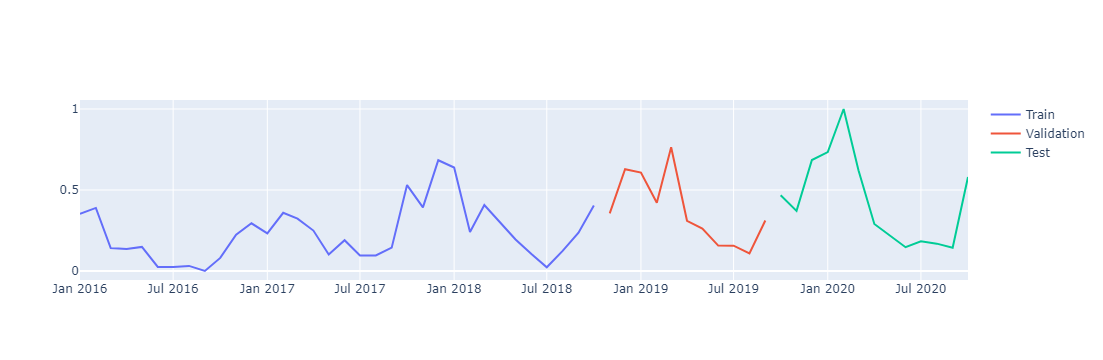

In [37]:
time_trainf = pd.to_datetime(time_train.flatten()).tolist()
time_valf = pd.to_datetime(time_val.flatten()).tolist()
time_testf = pd.to_datetime(time_test.flatten()).tolist()
dataf = data.flatten().tolist()
data_trainf = data_train.flatten().tolist()
data_valf = data_val.flatten().tolist()
data_testf = data_test.flatten().tolist()
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_trainf, y=data_trainf, mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=time_valf, y=data_valf, mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=time_testf, y=data_testf, mode='lines', name='Test'))
fig.show()

#### Ein-Schritt Vorhersage & Rekursive Mehrschrittvorhersage

In [38]:
def create_recurs_multi_data(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [39]:
time_steps = 4
Xr_train, yr_train = create_recurs_multi_data(data_train, data_train, time_steps)
Xr_val, yr_val = create_recurs_multi_data(data_val, data_val, time_steps)
Xr_test, yr_test = create_recurs_multi_data(data_test, data_test, time_steps)

In [40]:
print(Xr_train[0])
print('and')
print(yr_train[0])

[[0.35258769]
 [0.38937945]
 [0.14164827]
 [0.13576159]]
and
[0.1486387]


#### Direkte Mehrschrittvorhersage

In [41]:
def create_direct_multi_data(X, y, time_steps=1, future_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - future_steps + 1):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        future_values = y[i + time_steps : i + time_steps + future_steps]
        ys.append(future_values)
    return np.array(Xs), np.array(ys)

In [42]:
time_steps = 4
future_steps = 2
Xd_train, yd_train = create_direct_multi_data(data_train, data_train, time_steps, future_steps)
Xd_val, yd_val = create_direct_multi_data(data_val, data_val, time_steps, future_steps)
Xd_test, yd_test = create_direct_multi_data(data_test, data_test, time_steps, future_steps)

In [43]:
print(Xd_train[0])
print('and')
print(yd_train[0])

[[0.35258769]
 [0.38937945]
 [0.14164827]
 [0.13576159]]
and
[[0.1486387 ]
 [0.02532499]]


### 2.2 RNNs von Hand

2.2.1 Step by step

Nehmen wir an, wir haben eine Skala von 0 bis 1, wobei 0 für einen sonnigen Tag steht, 0,5 für einen bewölkten Tag und 1 für einen Regentag.<br>

Nehmen wir nun an, wir haben ein rollendes Fenster der Größe 3. Für jedes Fenster soll das RNN versuchen, die Wetterbedingungen des nächsten Tages vorherzusagen. Die Eingabe und Ausgabe des RNN wären Sequenzen von Wetterbedingungen.
Bei einer Folge von Wetterbedingungen [0, 0.5, 1, 0, 0.5, 1, 0] und einer Fenstergröße von 3 würden wir die folgenden Eingabe-Ausgabe-Paare erstellen:
- Input: [0, 0.5, 1], Target: 0
- Input: [0.5, 1, 0], Target: 0.5
- Input: [1, 0, 0.5], Target: 1
- Input: [0, 0.5, 1], Target: 0 <br>

In diesem Beispiel würde das RNN so trainiert, dass es die Wetterbedingungen des nächsten Tages auf der Grundlage der Wetterbedingungen der letzten drei Tage vorhersagt.

Zur Erinnerung: Die RNN Formeln
$$ℎ_𝑡=tanh(𝑊_{ℎℎ} ℎ_{𝑡−1}+𝑊_{𝑥ℎ} 𝑥_𝑡+𝑏_h)$$
$$𝑦 ̂=𝑊_{ℎ𝑦} ℎ_𝑡+𝑏_𝑦$$

Wir nehmen hier ein ganz einfaches RNN mit 5 hidden units an.

In [44]:
input_size = 3
hidden_size = 5
output_size = 1

In [45]:
Wxh = np.array([[ 0.1, -0.2,  0.3],
                [-0.3,  0.1,  0.2],
                [ 0.2,  0.4, -0.1],
                [-0.5,  0.3,  0.4],
                [ 0.3, -0.4,  0.2]])

Whh = np.array([[ 0.1, -0.3,  0.2,  0.1, -0.1],
                [ 0.2,  0.1, -0.2,  0.3,  0.1],
                [-0.3,  0.4,  0.1, -0.1,  0.2],
                [ 0.4, -0.1,  0.2,  0.3,  0.5],
                [-0.5,  0.1,  0.3, -0.2,  0.4]])

Why = np.array([[-0.1,  0.3, -0.2,  0.4, -0.3]])
by = np.array([[0.1]])

In [46]:
bh = np.zeros((hidden_size, 1))
hidden = np.zeros((hidden_size, 1))
hidden

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

Erster Input

In [47]:
x = np.array([[0, 0.5, 1]])
x.shape

(1, 3)

### Forward Pass

In [48]:
xs = {}
ys = {}
hs = {0: hidden}

In [49]:
xs[1] = np.array(x).reshape(input_size, 1)
xs

{1: array([[0. ],
        [0.5],
        [1. ]])}

In [50]:
hs[1] = np.tanh(np.dot(Wxh, xs[1]) + np.dot(Whh, hs[0]) + bh)
hs

{0: array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 1: array([[0.19737532],
        [0.24491866],
        [0.09966799],
        [0.50052021],
        [0.        ]])}

In [51]:
ys[1] = np.dot(Why, hs[1]) + by
ys

{1: array([[0.33401255]])}

In [52]:
y = 0

In [53]:
mse = ((y - ys[1]) ** 2) / 1
print(f"Mean Squared Error: {mse}")

Mean Squared Error: [[0.11156439]]


### BPTT

Zur Erinnerung: Die RNN Formeln
$$ℎ_𝑡=tanh(𝑊_{ℎℎ} ℎ_{𝑡−1}+𝑊_{𝑥ℎ} 𝑥_𝑡+𝑏_h)$$
$$𝑦 ̂=𝑊_{ℎ𝑦} ℎ_𝑡+𝑏_𝑦$$
Und Mean-Squared-Error als Loss
$$L = Σ_{i=1}^{N} (y_i - 𝑦 ̂_i)^2 / N$$

In [54]:
dLy = 2.0 * (ys[1] - y)
dLy

array([[0.6680251]])

In [55]:
dLWhy = np.dot(dLy, hs[1].T)
dLWhy

array([[0.13185167, 0.16361182, 0.06658072, 0.33436007, 0.        ]])

In [56]:
dLby = dLy
dLby

array([[0.6680251]])

In [57]:
dLh = np.dot(Why.T, dLy)
for t in reversed(range(1, len(hs))):
    temp = (1 - hs[t] * hs[t]) * dLh
    dLbh = temp
    dLWxh = np.dot(temp, xs[t].T)
    dLWhh = np.dot(temp, hs[t-1].T)
    dLh = np.dot(Whh.T, temp)
    print("dLbh: ",dLbh)
    print("dLWxh: ", dLWxh)
    print("dLWhh: ", dLWhh)
    print("dLh: ", dLh)

dLbh:  [[-0.06420008]
 [ 0.18838606]
 [-0.13227783]
 [ 0.20026845]
 [-0.20040753]]
dLWxh:  [[-0.         -0.03210004 -0.06420008]
 [ 0.          0.09419303  0.18838606]
 [-0.         -0.06613891 -0.13227783]
 [ 0.          0.10013423  0.20026845]
 [-0.         -0.10020377 -0.20040753]]
dLWhh:  [[-0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.]
 [-0. -0. -0. -0. -0.]
 [ 0.  0.  0.  0.  0.]
 [-0. -0. -0. -0. -0.]]
dLh:  [[ 0.2512517 ]
 [-0.0548801 ]
 [-0.08381358]
 [ 0.16348563]
 [ 0.01877426]]


In [58]:
learning_rate = 0.01

Wxh -= learning_rate * dLWxh
Whh -= learning_rate * dLWhh
Why -= learning_rate * dLWhy
by -= learning_rate * dLby
bh -= learning_rate * dLbh

In [59]:
Wxh

array([[ 0.1       , -0.199679  ,  0.300642  ],
       [-0.3       ,  0.09905807,  0.19811614],
       [ 0.2       ,  0.40066139, -0.09867722],
       [-0.5       ,  0.29899866,  0.39799732],
       [ 0.3       , -0.39899796,  0.20200408]])

In [60]:
Whh

array([[ 0.1, -0.3,  0.2,  0.1, -0.1],
       [ 0.2,  0.1, -0.2,  0.3,  0.1],
       [-0.3,  0.4,  0.1, -0.1,  0.2],
       [ 0.4, -0.1,  0.2,  0.3,  0.5],
       [-0.5,  0.1,  0.3, -0.2,  0.4]])

In [61]:
Why

array([[-0.10131852,  0.29836388, -0.20066581,  0.3966564 , -0.3       ]])

In [62]:
by

array([[0.09331975]])

In [63]:
bh

array([[ 0.000642  ],
       [-0.00188386],
       [ 0.00132278],
       [-0.00200268],
       [ 0.00200408]])

### Zweiter Forward-Pass

In [64]:
xs[2] = np.array(np.array([[0.5, 1, 0]])).reshape(input_size, 1)
xs

{1: array([[0. ],
        [0.5],
        [1. ]]),
 2: array([[0.5],
        [1. ],
        [0. ]])}

In [65]:
hs[2] = np.tanh(np.dot(Wxh, xs[2]) + np.dot(Whh, hs[1]) + bh)
hs

{0: array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 1: array([[0.19737532],
        [0.24491866],
        [0.09966799],
        [0.50052021],
        [0.        ]]),
 2: array([[-0.13201442],
        [ 0.14042942],
        [ 0.46263119],
        [ 0.26506085],
        [-0.37256078]])}

In [66]:
ys[1] = np.dot(Why, hs[1]) + by
ys

{1: array([[0.32493144]])}

In [67]:
y = 0.5
y_hat = 0.31361781

In [68]:
mse = ((y - y_hat) ** 2) / 1
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.034738320749196104


### Leichte Automatisierung

In [69]:
import numpy as np

In [70]:
def initialize_weights(input_size, hidden_size, output_size):
    Wxh = np.random.randn(hidden_size, input_size) * np.sqrt(1. / (input_size + hidden_size))
    Whh = np.random.randn(hidden_size, hidden_size) * np.sqrt(1. / (hidden_size + hidden_size))
    Why = np.random.randn(output_size, hidden_size) * np.sqrt(1. / (hidden_size + output_size))
    bh = np.zeros((hidden_size, 1))
    by = np.zeros((output_size, 1))
    hidden = np.zeros((hidden_size, 1))
    weights = {'Wxh': Wxh, 'Whh': Whh, 'Why': Why, 'bh': bh, 'by': by, 'hidden': hidden}
    
    return weights

In [71]:
def forward_pass(xs, hs_p, Wxh, Whh, Why, bh, by, ts):
    hs = np.tanh(np.dot(Wxh, xs) + np.dot(Whh, hs_p) + bh)
    ys = np.dot(Why, hs) + by
    mse = ((ts - ys) ** 2) / 1
    print(f"Mean Squared Error: {mse}")
    
    return ys, hs

In [72]:
def bptt(t, ys, xs, ts, hs, Wxh, Whh, Why, bh, by, learning_rate):
    dLWxh = np.zeros_like(Wxh)
    dLWhh = np.zeros_like(Whh)
    dLWhy = np.zeros_like(Why)
    dLbh = np.zeros_like(bh)
    dLby = np.zeros_like(by)
    
    dLy = 2.0 * (ys - ts)
    dLWhy += np.dot(dLy, hs[t].T)
    dLby += dLy
    dLh = np.dot(Why.T, dLy)
    for t in reversed(range(1, len(hs))):
        temp = (1 - hs[t] * hs[t]) * dLh
        dLbh += temp
        dLWxh += np.dot(temp, xs.T)
        dLWhh += np.dot(temp, hs[t-1].T)
        dLh = np.dot(Whh.T, temp)
        print("dLbh: ",dLbh)
        print("dLWxh: ", dLWxh)
        print("dLWhh: ", dLWhh)
        print("dLh: ", dLh)
    
    Wxh -= learning_rate * dLWxh
    Whh -= learning_rate * dLWhh
    Why -= learning_rate * dLWhy
    bh -= learning_rate * dLbh
    by -= learning_rate * dLby
    
    return Wxh, Whh, Why, bh, by

In [73]:
def training(input_sequence, input_size, hidden_size, output_size, learning_rate):
    initial_weights = initialize_weights(input_size, hidden_size, output_size)
    
    inputs = [input_sequence[i:i+input_size] for i in range(len(input_sequence)-input_size)]
    inputs = np.array(inputs).reshape(len(inputs), input_size, 1)
    targets = input_sequence[input_size:]
    targets = np.array(targets).reshape(len(targets),output_size, 1)
    
    xs = {}
    ts = {}
    ys = {}
    hs = {0: initial_weights['hidden']}
    Wxhs = {1: initial_weights['Wxh']}
    Whhs = {1: initial_weights['Whh']}
    Whys = {1: initial_weights['Why']}
    bhs = {1: initial_weights['bh']}
    bys = {1: initial_weights['by']}    
    for t in range(1, 1+len(inputs)):
        xs[t] = inputs[t-1]
        ts[t] = targets[t-1]
        ys[t], hs[t] = forward_pass(xs[t], hs[t-1], Wxhs[t], Whhs[t], Whys[t], bhs[t], bys[t], ts[t])
        Wxhs[t+1], Whhs[t+1], Whys[t+1], bhs[t+1], bys[t+1] = bptt(t, ys[t], xs[t], ts[t], hs, Wxhs[t], Whhs[t], Whys[t], bhs[t], bys[t], learning_rate)

In [74]:
input_size = 3
hidden_size = 5
output_size = 1

In [75]:
input_sequence = [0, 0.5, 1, 0, 0.5, 1, 0]

In [76]:
learning_rate = 0.01

In [77]:
training(input_sequence, input_size, hidden_size, output_size, learning_rate)

Mean Squared Error: [[0.00063053]]
dLbh:  [[ 0.00471343]
 [-0.00206399]
 [ 0.00304214]
 [-0.00791009]
 [ 0.01721669]]
dLWxh:  [[ 0.          0.00235671  0.00471343]
 [ 0.         -0.00103199 -0.00206399]
 [ 0.          0.00152107  0.00304214]
 [ 0.         -0.00395504 -0.00791009]
 [ 0.          0.00860834  0.01721669]]
dLWhh:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
dLh:  [[ 0.01095194]
 [ 0.01615794]
 [-0.00012924]
 [ 0.00336854]
 [-0.01019784]]
Mean Squared Error: [[0.0908381]]
dLbh:  [[ 0.05154444]
 [-0.02772039]
 [ 0.03662269]
 [-0.10478716]
 [ 0.16527922]]
dLWxh:  [[ 0.02577222  0.05154444  0.        ]
 [-0.01386019 -0.02772039  0.        ]
 [ 0.01831135  0.03662269  0.        ]
 [-0.05239358 -0.10478716  0.        ]
 [ 0.08263961  0.16527922  0.        ]]
dLWhh:  [[ 0.00952675 -0.01712744  0.013665   -0.01813311 -0.01254758]
 [-0.00512345  0.00921107 -0.00734898  0.00975191  0.00674804]
 [ 0.00676883 -0.01216917  0.00970908 -0.0

<div class="alert alert-info">
    <h5> Aufgabe 2.1) Vorbereitung Daten für Deep Learning Zeitreihenanalyse </h5><br>
- Bereite die Stromverbrauchsdaten des Haushalts 8 im Mai 2012 für die Zeitreihenanalyse vor<br>
- Visualisiere die Trainings-, Val- und Testdaten sowie die Einteilung mindestens eines Fensters<br>
</div>

In [78]:
# Dein Code

<div class="alert alert-info">
    <h5> Aufgabe 2.2) RNNs von Hand </h5><br>
- Vergleiche die Rechenschritte unseres einfachen RNN Modells mit deinem theoretischen Verständnis des Modells. Wo gibt es noch Unklarheiten?<br>
- Kommentiere in den Code, was wo passiert.<br>
</div>

In [79]:
# Dein Code

In [118]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Input

### 2.2 Fortsetzung: RNNs mit Tensorflow

In [81]:
input_size = 3 #window_size
hidden_size = 5
output_size = 1

In [82]:
# Prepare your data
sequence = [0, 0.5, 1, 0, 0.5, 1, 0]

In [83]:
X = [sequence[i:i+input_size] for i in range(len(sequence)-input_size)]
y = sequence[input_size:]

In [84]:
X

[[0, 0.5, 1], [0.5, 1, 0], [1, 0, 0.5], [0, 0.5, 1]]

In [85]:
X = tf.reshape(X, (len(X), input_size, 1))  
y = tf.reshape(y, (len(y), 1))

In [86]:
X

<tf.Tensor: shape=(4, 3, 1), dtype=float32, numpy=
array([[[0. ],
        [0.5],
        [1. ]],

       [[0.5],
        [1. ],
        [0. ]],

       [[1. ],
        [0. ],
        [0.5]],

       [[0. ],
        [0.5],
        [1. ]]], dtype=float32)>

In [119]:
# Define the model
simple_RNN_model = Sequential([
    Input(shape=(input_size, 1)),  # Definiert die Form der Eingabedaten
    SimpleRNN(hidden_size),        # SimpleRNN-Schicht mit 5 Neuronen
    Dense(output_size)             # Ausgangsschicht mit einem Ausgangswert
])

In [120]:
# Compile the model
simple_RNN_model.compile(loss='mean_squared_error', optimizer='adam')

In [121]:
# Train the model
simple_RNN_model.fit(X, y, epochs=100)  # 'epochs' is the number of times the training process will iterate over the entire dataset

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - loss: 0.2802
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2265
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1824
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1466
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1178
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0943
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0745
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0579
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0440
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0325
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0233
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0163
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0116
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0080
Epoch 16/100
1/1 ━━

In [122]:
# Make predictions on the input data
simple_RNN_predictions = simple_RNN_model.predict(X)

# Print the results
for i, prediction in enumerate(simple_RNN_predictions):
    print(f"Input:")
    print(f"{X[i]}")
    print(f"Target: {y[i]}, Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Input:
[[0. ]
 [0.5]
 [1. ]]
Target: [0.], Prediction: [-0.00231224]
Input:
[[0.5]
 [1. ]
 [0. ]]
Target: [0.5], Prediction: [0.50115484]
Input:
[[1. ]
 [0. ]
 [0.5]]
Target: [1.], Prediction: [1.0025759]
Input:
[[0. ]
 [0.5]
 [1. ]]
Target: [0.], Prediction: [-0.00231224]


### Jetzt mit interessanteren Daten

In [123]:
em = pd.read_csv("em_HH8.csv", index_col=0)
em['Zeit'] = pd.to_datetime(em['Zeit'])
em['Zeit'].freq = 'H'
em.set_index('Zeit', inplace=True)
em.head()

,Strom
Zeit,
2012-05-01 00:00:00,834.0
2012-05-01 01:00:00,824.0
2012-05-01 02:00:00,681.0
2012-05-01 03:00:00,530.0
2012-05-01 04:00:00,672.0


In [124]:
scaler = MinMaxScaler()
scaler.fit(em)
ems = scaler.transform(em)
ems[:5]

array([[0.38339022],
       [0.37201365],
       [0.20932878],
       [0.03754266],
       [0.19908987]])

In [125]:
data = ems

In [126]:
time = em.index.values.reshape(-1, 1)
time[:5]

array([['2012-05-01T00:00:00.000000000'],
       ['2012-05-01T01:00:00.000000000'],
       ['2012-05-01T02:00:00.000000000'],
       ['2012-05-01T03:00:00.000000000'],
       ['2012-05-01T04:00:00.000000000']], dtype='datetime64[ns]')

In [127]:
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.2)

In [128]:
data[:5]

array([[0.38339022],
       [0.37201365],
       [0.20932878],
       [0.03754266],
       [0.19908987]])

In [129]:
data_train, data_val, data_test = data[0:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

In [130]:
time_train = time[:train_size]
time_val = time[train_size:train_size+val_size]
time_test = time[train_size+val_size:]

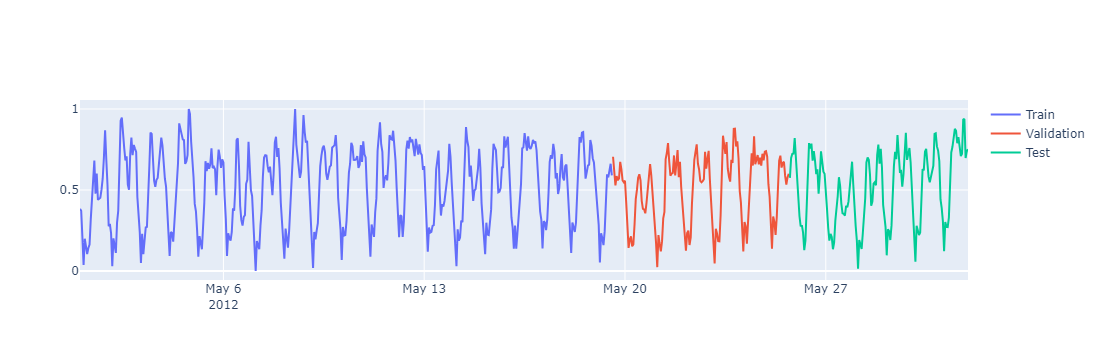

In [131]:
time_trainf = pd.to_datetime(time_train.flatten()).tolist()
time_valf = pd.to_datetime(time_val.flatten()).tolist()
time_testf = pd.to_datetime(time_test.flatten()).tolist()
dataf = data.flatten().tolist()
data_trainf = data_train.flatten().tolist()
data_valf = data_val.flatten().tolist()
data_testf = data_test.flatten().tolist()
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_trainf, y=data_trainf, mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=time_valf, y=data_valf, mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=time_testf, y=data_testf, mode='lines', name='Test'))
fig.show()

#### Ein-Schritt-Vorhersage

In [132]:
input_size = 72 #time_steps
hidden_size = 50
output_size = 1

In [133]:
Xr_train, yr_train = create_recurs_multi_data(data_train, data_train, input_size)
Xr_val, yr_val = create_recurs_multi_data(data_val, data_val, input_size)
Xr_test, yr_test = create_recurs_multi_data(data_test, data_test, input_size)

In [134]:
print(Xr_train[0])
print('and')
print(yr_train[0])

[[0.38339022]
 [0.37201365]
 [0.20932878]
 [0.03754266]
 [0.19908987]
 [0.15699659]
 [0.10466439]
 [0.14220705]
 [0.16382253]
 [0.3185438 ]
 [0.44482366]
 [0.49374289]
 [0.6814562 ]
 [0.4778157 ]
 [0.60182025]
 [0.43913538]
 [0.44482366]
 [0.45278726]
 [0.50170648]
 [0.57110353]
 [0.70079636]
 [0.86916951]
 [0.6894198 ]
 [0.53242321]
 [0.27645051]
 [0.29010239]
 [0.23321957]
 [0.02957907]
 [0.20136519]
 [0.16040956]
 [0.11149033]
 [0.29920364]
 [0.37201365]
 [0.64732651]
 [0.92718999]
 [0.94653015]
 [0.82025028]
 [0.75881684]
 [0.68259386]
 [0.70875995]
 [0.53356086]
 [0.50170648]
 [0.72013652]
 [0.82366325]
 [0.71558589]
 [0.778157  ]
 [0.75540387]
 [0.73492605]
 [0.45620023]
 [0.36405006]
 [0.24004551]
 [0.05005688]
 [0.2298066 ]
 [0.10352673]
 [0.18316268]
 [0.26848692]
 [0.27189989]
 [0.53697383]
 [0.64163823]
 [0.85437998]
 [0.84641638]
 [0.70079636]
 [0.55858931]
 [0.51990899]
 [0.56313993]
 [0.5745165 ]
 [0.65870307]
 [0.778157  ]
 [0.82366325]
 [0.77360637]
 [0.65073948]
 [0.57

In [135]:
RNN_model = Sequential([
    Input(shape=(input_size, 1)),  # Definiert die Form der Eingabedaten
    SimpleRNN(hidden_size),        # SimpleRNN-Schicht mit der angegebenen Anzahl von Neuronen
    Dense(output_size)             # Ausgangsschicht mit einem Ausgangswert
])

In [136]:
RNN_model.compile(loss='mean_squared_error', optimizer='adam')

In [137]:
RNN_model.fit(Xr_train, yr_train, epochs=100, validation_data=(Xr_val, yr_val))

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1037 - val_loss: 0.0320
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270 - val_loss: 0.0118
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - val_loss: 0.0095
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0069
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0070
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [138]:
i=0

In [139]:
RNN_predictions = RNN_model.predict(Xr_test)
print(f"Input: {Xr_test[i]}, Target: {yr_test[i]}, Prediction: {RNN_predictions[i]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Input: [[0.5745165 ]
 [0.69738339]
 [0.72354949]
 [0.72468714]
 [0.82025028]
 [0.68600683]
 [0.61547213]
 [0.49032992]
 [0.33788396]
 [0.27531286]
 [0.28327645]
 [0.23663254]
 [0.12855518]
 [0.18885097]
 [0.37201365]
 [0.62343572]
 [0.78953356]
 [0.75540387]
 [0.78612059]
 [0.6814562 ]
 [0.73947668]
 [0.6814562 ]
 [0.59840728]
 [0.62798635]
 [0.4778157 ]
 [0.59044369]
 [0.73833902]
 [0.67690557]
 [0.61319681]
 [0.60068259]
 [0.51194539]
 [0.38680319]
 [0.26848692]
 [0.18771331]
 [0.22866894]
 [0.21046644]
 [0.13424346]
 [0.17633675]
 [0.3105802 ]
 [0.370876  ]
 [0.46302617]
 [0.57906712]
 [0.52559727]
 [0.41751991]
 [0.35608646]
 [0.35381115]
 [0.34129693]
 [0.40273038]
 [0.39362912]
 [0.42775882]
 [0.50967008]
 [0.56996587]
 [0.67463026]
 [0.53356086]
 [0.37542662]
 [0.27872582]
 [0.18771331]
 [0.01478953]
 [0.19112628]
 [0.15358362]
 [0.13651877]
 [0.23435722]
 [0.32992036]
 [0.44937429]
 [0.67007964]
 [0.70079636]
 [0.68600683]
 [0.59385666]
 [0

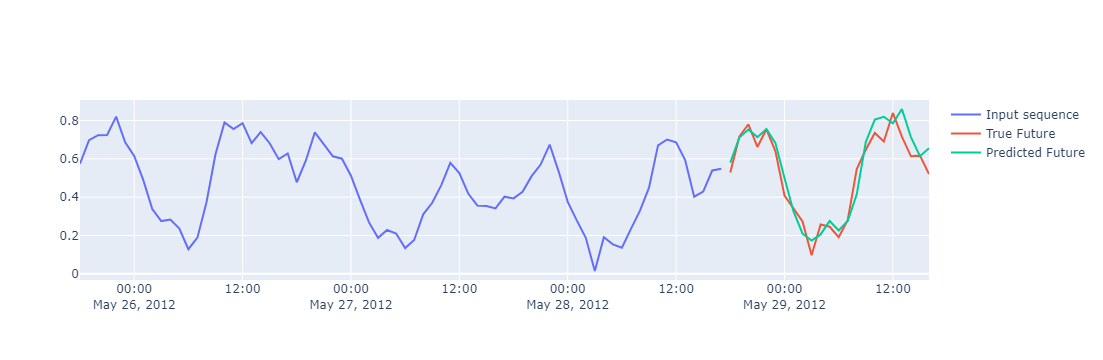

In [140]:
fig = go.Figure()

time_steps_X = pd.to_datetime(time_test[:len(Xr_test[i])].flatten()).tolist()
time_steps_y = pd.to_datetime(time_test[len(Xr_test[i]):len(Xr_test[i]) + len(yr_test[i:i+23])].flatten()).tolist()

fig.add_trace(go.Scatter(x=time_steps_X, y=Xr_test[i].flatten().tolist(), mode='lines', name='Input sequence'))
fig.add_trace(go.Scatter(x=time_steps_y, y=yr_test[i:i+23].flatten().tolist(), mode='lines', name='True Future'))
fig.add_trace(go.Scatter(x=time_steps_y, y=RNN_predictions.flatten().tolist(), mode='lines', name='Predicted Future'))

fig.show()

In [141]:
mse = mean_squared_error(yr_test[i:i+23], RNN_predictions[i:i+23])
print('Test MSE: ', mse)

Test MSE:  0.005386077463715647


### 2.3 LSTMs mit Tensorflow

In [143]:
model_lstm = Sequential([
    Input(shape=(input_size, 1)),  # Definiert die Form der Eingabedaten
    LSTM(100, activation='relu'),  # LSTM-Schicht mit 100 Neuronen und ReLU-Aktivierung
    Dense(1)                       # Ausgangsschicht mit einem Ausgangswert
])

In [145]:
# Modell kompilieren
model_lstm.compile(optimizer='adam', loss='mse')

In [146]:
history_lstm = model_lstm.fit(
    Xr_train, yr_train, 
    epochs=10, 
    validation_data=(Xr_val, yr_val),  
    batch_size=4, 
    verbose=1, 
    shuffle=False
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1218 - val_loss: 0.0393
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0518 - val_loss: 0.0327
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0440 - val_loss: 0.0285
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0380 - val_loss: 0.0230
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0294 - val_loss: 0.0163
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0221 - val_loss: 0.0137
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0205 - val_loss: 0.0129
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0186 - val_loss: 0.0120
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0173 - val_loss: 0.0113
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0161 - val_loss: 0.0105


In [147]:
predictions_lstm = model_lstm.predict(Xr_test)
i=0
print(f"Input: {Xr_test[i]}, Target: {yr_test[i]}, Prediction: {predictions_lstm[i]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Input: [[0.5745165 ]
 [0.69738339]
 [0.72354949]
 [0.72468714]
 [0.82025028]
 [0.68600683]
 [0.61547213]
 [0.49032992]
 [0.33788396]
 [0.27531286]
 [0.28327645]
 [0.23663254]
 [0.12855518]
 [0.18885097]
 [0.37201365]
 [0.62343572]
 [0.78953356]
 [0.75540387]
 [0.78612059]
 [0.6814562 ]
 [0.73947668]
 [0.6814562 ]
 [0.59840728]
 [0.62798635]
 [0.4778157 ]
 [0.59044369]
 [0.73833902]
 [0.67690557]
 [0.61319681]
 [0.60068259]
 [0.51194539]
 [0.38680319]
 [0.26848692]
 [0.18771331]
 [0.22866894]
 [0.21046644]
 [0.13424346]
 [0.17633675]
 [0.3105802 ]
 [0.370876  ]
 [0.46302617]
 [0.57906712]
 [0.52559727]
 [0.41751991]
 [0.35608646]
 [0.35381115]
 [0.34129693]
 [0.40273038]
 [0.39362912]
 [0.42775882]
 [0.50967008]
 [0.56996587]
 [0.67463026]
 [0.53356086]
 [0.37542662]
 [0.27872582]
 [0.18771331]
 [0.01478953]
 [0.19112628]
 [0.15358362]
 [0.13651877]
 [0.23435722]
 [0.32992036]
 [0.44937429]
 [0.67007964]
 [0.70079636]
 [0.68600683]
 [0.59385666]
 [0

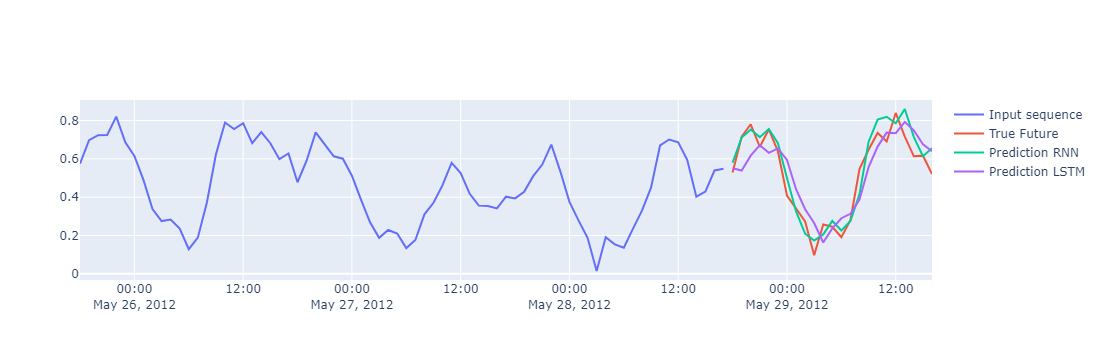

In [148]:
fig = go.Figure()

time_steps_X = pd.to_datetime(time_test[:len(Xr_test[0])].flatten()).tolist()
time_steps_y = pd.to_datetime(time_test[len(Xr_test[0]):len(Xr_test[0]) + len(yr_test[0:23])].flatten()).tolist()

fig.add_trace(go.Scatter(x=time_steps_X, y=Xr_test[0].flatten().tolist(), mode='lines', name='Input sequence'))
fig.add_trace(go.Scatter(x=time_steps_y, y=yr_test[0:23].flatten().tolist(), mode='lines', name='True Future'))
fig.add_trace(go.Scatter(x=time_steps_y, y=RNN_predictions.flatten().tolist(), mode='lines', name='Prediction RNN'))
fig.add_trace(go.Scatter(x=time_steps_y, y=predictions_lstm.flatten().tolist(), mode='lines', name='Prediction LSTM'))

fig.show()

In [149]:
mse_RNN = round(mean_squared_error(yr_test[i:i+23], RNN_predictions[i:i+23]),4)
mse_LSTM = round(mean_squared_error(yr_test[i:i+23], predictions_lstm[i:i+23]),4)
print('Test MSE RNN: ', mse_RNN, ', Test MSE LSTM: ', mse_LSTM)

Test MSE RNN:  0.0054 , Test MSE LSTM:  0.0115


<div class="alert alert-info">
    <h5> Aufgabe 2.3 und 2.4) RNNs und LSTMs mit Tensorflow </h5><br>


- Experimentiere mit input_size, hidden_size, split in Training-, Val-, und Testdaten. Was passiert hier mit den Modellergebnissen und im Vergleich von RNN und LSTM?<br>
- Visualisiere auch andere Fenster der Testdaten. Kannst du etwas beobachten?<br>
- Kannst du auch mit output_size experimentieren? Was muss sich dann alles ändern?<br>
- Wende RNN und LSTM auf den erweiterten Datensatz an. Was kannst du beobachten?
</div>

In [88]:
# Dein Code